# MLP 206
* Operate on 16000 GenCode 34 seqs.
* 5-way cross validation. Save best model per CV.
* Report mean accuracy from final re-validation with best 5.
* Use Adam with a learn rate decay schdule.

In [1]:
NC_FILENAME='ncRNA.gc34.processed.fasta'
PC_FILENAME='pcRNA.gc34.processed.fasta'
DATAPATH=""
try:
    from google.colab import drive
    IN_COLAB = True
    PATH='/content/drive/'
    drive.mount(PATH)
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    NC_FILENAME = DATAPATH+NC_FILENAME
    PC_FILENAME = DATAPATH+PC_FILENAME
except:
    IN_COLAB = False
    DATAPATH="" 

EPOCHS=200
SPLITS=5
K=5
VOCABULARY_SIZE=4**K+1   # e.g. K=3 => 64 DNA K-mers + 'NNN'
EMBED_DIMEN=16
FILENAME='MLP206'
NEURONS=16

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import GRU
from keras.layers import Dense
from keras.layers import LayerNormalization
import time
dt='float32'
tf.keras.backend.set_floatx(dt)

## Build model

In [3]:
def compile_model(model):
    adam_default_learn_rate = 0.001
    schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate = adam_default_learn_rate*10,
        #decay_steps=100000, decay_rate=0.96, staircase=True)
        decay_steps=10000, decay_rate=0.99, staircase=True)
    # learn rate = initial_learning_rate * decay_rate ^ (step / decay_steps)
    opt = tf.keras.optimizers.Adam(learning_rate=schedule)
    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    print("COMPILE...")
    model.compile(loss=bc, optimizer=opt, metrics=["accuracy"])
    print("...COMPILED")
    return model

def build_model(maxlen):
    act="elu"
    #embed_layer  = keras.layers.Embedding(
    #    VOCABULARY_SIZE,EMBED_DIMEN,input_length=maxlen);
    dense1_layer = keras.layers.Dense(NEURONS, activation=act,dtype=dt,
                                      input_dim=VOCABULARY_SIZE)
    dense2_layer = keras.layers.Dense(NEURONS, activation=act,dtype=dt)
    #dense3_layer = keras.layers.Dense(NEURONS, activation=act,dtype=dt)
    output_layer = keras.layers.Dense(1,  activation="sigmoid",dtype=dt)
    mlp = keras.models.Sequential()
    #mlp.add(embed_layer)
    mlp.add(dense1_layer)
    mlp.add(dense2_layer)
    #mlp.add(dense3_layer)
    mlp.add(output_layer)
    mlpc = compile_model(mlp)
    return mlpc

## Load and partition sequences

In [4]:
# Assume file was preprocessed to contain one line per seq.
# Prefer Pandas dataframe but df does not support append.
# For conversion to tensor, must avoid python lists.
def load_fasta(filename,label):
    DEFLINE='>'
    labels=[]
    seqs=[]
    lens=[]
    nums=[]
    num=0
    with open (filename,'r') as infile:
        for line in infile:
            if line[0]!=DEFLINE:
                seq=line.rstrip()
                num += 1   # first seqnum is 1
                seqlen=len(seq)
                nums.append(num)
                labels.append(label)
                seqs.append(seq)
                lens.append(seqlen)
    df1=pd.DataFrame(nums,columns=['seqnum'])
    df2=pd.DataFrame(labels,columns=['class'])
    df3=pd.DataFrame(seqs,columns=['sequence'])
    df4=pd.DataFrame(lens,columns=['seqlen'])
    df=pd.concat((df1,df2,df3,df4),axis=1)
    return df

def separate_X_and_y(data):
    y=   data[['class']].copy()
    X=   data.drop(columns=['class','seqnum','seqlen'])
    return (X,y)



## Make K-mers

In [5]:
def make_kmer_table(K):
    npad='N'*K
    shorter_kmers=['']
    for i in range(K):
        longer_kmers=[]
        for mer in shorter_kmers:
            longer_kmers.append(mer+'A')
            longer_kmers.append(mer+'C')
            longer_kmers.append(mer+'G')
            longer_kmers.append(mer+'T')
        shorter_kmers = longer_kmers
    all_kmers = shorter_kmers
    kmer_dict = {}
    kmer_dict[npad]=0
    value=1
    for mer in all_kmers:
        kmer_dict[mer]=value
        value += 1
    return kmer_dict

KMER_TABLE=make_kmer_table(K)

def strings_to_vectors(data,uniform_len):
    all_seqs=[]
    for seq in data['sequence']:
        i=0
        seqlen=len(seq)
        kmers=[]
        while i < seqlen-K+1 -1:  # stop at minus one for spaced seed
            #kmer=seq[i:i+2]+seq[i+3:i+5]    # SPACED SEED 2/1/2 for K=4
            kmer=seq[i:i+K]  
            i += 1
            value=KMER_TABLE[kmer]
            kmers.append(value)
        pad_val=0
        while i < uniform_len:
            kmers.append(pad_val)
            i += 1
        all_seqs.append(kmers)
    pd2d=pd.DataFrame(all_seqs)
    return pd2d   # return 2D dataframe, uniform dimensions

In [6]:
def make_kmers(MAXLEN,train_set):
    (X_train_all,y_train_all)=separate_X_and_y(train_set)
    X_train_kmers=strings_to_vectors(X_train_all,MAXLEN)
    # From pandas dataframe to numpy to list to numpy
    num_seqs=len(X_train_kmers)
    tmp_seqs=[]
    for i in range(num_seqs):
        kmer_sequence=X_train_kmers.iloc[i]
        tmp_seqs.append(kmer_sequence)
    X_train_kmers=np.array(tmp_seqs)
    tmp_seqs=None
    labels=y_train_all.to_numpy()
    return (X_train_kmers,labels)

In [7]:
def make_frequencies(Xin):
    Xout=[]
    VOCABULARY_SIZE= 4**K + 1  # plus one for 'NNN'
    for seq in Xin:
        freqs =[0] * VOCABULARY_SIZE
        total = 0
        for kmerval in seq:
            freqs[kmerval] += 1
            total += 1
        for c in range(VOCABULARY_SIZE):
            freqs[c] = freqs[c]/total
        Xout.append(freqs)
    Xnum = np.asarray(Xout)
    return (Xnum)
def make_slice(data_set,min_len,max_len):
    slice = data_set.query('seqlen <= '+str(max_len)+' & seqlen>= '+str(min_len))
    return slice

## Cross validation

In [8]:
def do_cross_validation(X,y,given_model):
    cv_scores = []
    fold=0
    splitter = ShuffleSplit(n_splits=SPLITS, test_size=0.1, random_state=37863)
    for train_index,valid_index in splitter.split(X):
        fold += 1
        X_train=X[train_index] # use iloc[] for dataframe
        y_train=y[train_index]
        X_valid=X[valid_index]
        y_valid=y[valid_index]        
        # Avoid continually improving the same model.
        model = compile_model(keras.models.clone_model(given_model))
        bestname=DATAPATH+FILENAME+".cv."+str(fold)+".best"
        mycallbacks = [keras.callbacks.ModelCheckpoint(
            filepath=bestname, save_best_only=True, 
            monitor='val_accuracy', mode='max')]   
        print("FIT")
        start_time=time.time()
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=EPOCHS, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                callbacks=mycallbacks,
                validation_data=(X_valid,y_valid) )
        end_time=time.time()
        elapsed_time=(end_time-start_time)                        
        print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()
        best_model=keras.models.load_model(bestname)
        scores = best_model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))
        cv_scores.append(scores[1] * 100)  
    print()
    print("%d-way Cross Validation mean %.2f%% (+/- %.2f%%)" % (fold, np.mean(cv_scores), np.std(cv_scores)))

## Train on RNA lengths 200-1Kb

In [9]:
MINLEN=200
MAXLEN=1000
print("Load data from files.")
nc_seq=load_fasta(NC_FILENAME,0)
pc_seq=load_fasta(PC_FILENAME,1)
train_set=pd.concat((nc_seq,pc_seq),axis=0)
nc_seq=None
pc_seq=None
print("Ready: train_set")
#train_set
print ("Compile the model")
model=build_model(MAXLEN)
print ("Summarize the model")
print(model.summary())  # Print this only once
model.save(DATAPATH+FILENAME+'.model')
print ("Data prep")
subset=make_slice(train_set,MINLEN,MAXLEN)# One array to two: X and y
print ("Data reshape")
(X_train,y_train)=make_kmers(MAXLEN,subset)
X_train=make_frequencies(X_train)

Load data from files.
Ready: train_set
Compile the model
COMPILE...
...COMPILED
Summarize the model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                16416     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 16,705
Trainable params: 16,705
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: MLP206.model/assets
Data prep
Data reshape


Cross valiation
COMPILE...
...COMPILED
FIT
Epoch 1/200
453/453 [==============================] - 2s 5ms/step - loss: 0.4197 - accuracy: 0.8073 - val_loss: 0.3234 - val_accuracy: 0.8659
Epoch 2/200
453/453 [==============================] - 2s 4ms/step - loss: 0.3424 - accuracy: 0.8536 - val_loss: 0.3651 - val_accuracy: 0.8430
Epoch 3/200
453/453 [==============================] - 2s 4ms/step - loss: 0.3349 - accuracy: 0.8566 - val_loss: 0.3131 - val_accuracy: 0.8752
Epoch 4/200
453/453 [==============================] - 2s 5ms/step - loss: 0.3234 - accuracy: 0.8611 - val_loss: 0.3100 - val_accuracy: 0.8765
Epoch 5/200
453/453 [==============================] - 1s 3ms/step - loss: 0.3215 - accuracy: 0.8666 - val_loss: 0.3235 - val_accuracy: 0.8653
Epoch 6/200
453/453 [==============================] - 1s 3ms/step - loss: 0.3185 - accuracy: 0.8669 - val_loss: 0.3144 - val_accuracy: 0.8727
Epoch 7/200
453/453 [==============================] - 1s 2ms/step - loss: 0.3139 - accuracy: 0.867

453/453 [==============================] - 1s 3ms/step - loss: 0.2073 - accuracy: 0.9151 - val_loss: 0.4235 - val_accuracy: 0.8516
Epoch 55/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2031 - accuracy: 0.9163 - val_loss: 0.4051 - val_accuracy: 0.8498
Epoch 56/200
453/453 [==============================] - 2s 4ms/step - loss: 0.1975 - accuracy: 0.9193 - val_loss: 0.4120 - val_accuracy: 0.8436
Epoch 57/200
453/453 [==============================] - 2s 5ms/step - loss: 0.2014 - accuracy: 0.9160 - val_loss: 0.4030 - val_accuracy: 0.8516
Epoch 58/200
453/453 [==============================] - 2s 5ms/step - loss: 0.1964 - accuracy: 0.9198 - val_loss: 0.4289 - val_accuracy: 0.8547
Epoch 59/200
453/453 [==============================] - 2s 4ms/step - loss: 0.1951 - accuracy: 0.9204 - val_loss: 0.4853 - val_accuracy: 0.8516
Epoch 60/200
453/453 [==============================] - 2s 5ms/step - loss: 0.1896 - accuracy: 0.9239 - val_loss: 0.4462 - val_accuracy: 0.8510
Epoch

Epoch 111/200
453/453 [==============================] - 2s 4ms/step - loss: 0.0777 - accuracy: 0.9698 - val_loss: 1.2567 - val_accuracy: 0.8250
Epoch 112/200
453/453 [==============================] - 1s 2ms/step - loss: 0.0762 - accuracy: 0.9707 - val_loss: 1.2419 - val_accuracy: 0.8330
Epoch 113/200
453/453 [==============================] - 1s 2ms/step - loss: 0.0705 - accuracy: 0.9730 - val_loss: 1.3123 - val_accuracy: 0.8156
Epoch 114/200
453/453 [==============================] - 1s 3ms/step - loss: 0.0760 - accuracy: 0.9696 - val_loss: 1.2268 - val_accuracy: 0.8094
Epoch 115/200
453/453 [==============================] - 1s 3ms/step - loss: 0.0722 - accuracy: 0.9732 - val_loss: 1.3095 - val_accuracy: 0.8212
Epoch 116/200
453/453 [==============================] - 1s 2ms/step - loss: 0.0698 - accuracy: 0.9736 - val_loss: 1.4113 - val_accuracy: 0.8212
Epoch 117/200
453/453 [==============================] - 1s 3ms/step - loss: 0.0581 - accuracy: 0.9778 - val_loss: 1.4928 - val_ac

453/453 [==============================] - 1s 2ms/step - loss: 0.0187 - accuracy: 0.9939 - val_loss: 2.2874 - val_accuracy: 0.8274
Epoch 168/200
453/453 [==============================] - 1s 2ms/step - loss: 0.0073 - accuracy: 0.9988 - val_loss: 2.4491 - val_accuracy: 0.8256
Epoch 169/200
453/453 [==============================] - 1s 2ms/step - loss: 0.0255 - accuracy: 0.9910 - val_loss: 2.4973 - val_accuracy: 0.8144
Epoch 170/200
453/453 [==============================] - 1s 2ms/step - loss: 0.0285 - accuracy: 0.9908 - val_loss: 2.6806 - val_accuracy: 0.8274
Epoch 171/200
453/453 [==============================] - 1s 2ms/step - loss: 0.0576 - accuracy: 0.9814 - val_loss: 2.4458 - val_accuracy: 0.8144
Epoch 172/200
453/453 [==============================] - 1s 2ms/step - loss: 0.0093 - accuracy: 0.9978 - val_loss: 2.3957 - val_accuracy: 0.8187
Epoch 173/200
453/453 [==============================] - 1s 2ms/step - loss: 0.0092 - accuracy: 0.9981 - val_loss: 2.4537 - val_accuracy: 0.8175

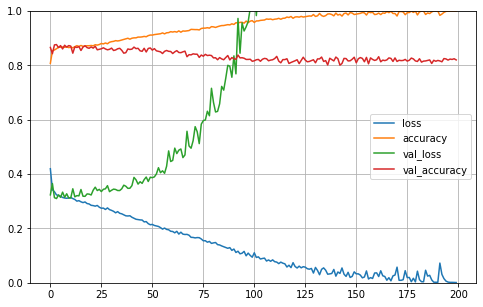

accuracy: 87.65%
COMPILE...
...COMPILED
FIT
Epoch 1/200
453/453 [==============================] - 2s 3ms/step - loss: 0.4146 - accuracy: 0.8083 - val_loss: 0.3732 - val_accuracy: 0.8461
Epoch 2/200
453/453 [==============================] - 1s 2ms/step - loss: 0.3398 - accuracy: 0.8558 - val_loss: 0.3579 - val_accuracy: 0.8461
Epoch 3/200
453/453 [==============================] - 2s 3ms/step - loss: 0.3309 - accuracy: 0.8592 - val_loss: 0.3628 - val_accuracy: 0.8485
Epoch 4/200
453/453 [==============================] - 2s 3ms/step - loss: 0.3217 - accuracy: 0.8650 - val_loss: 0.3639 - val_accuracy: 0.8504
Epoch 5/200
453/453 [==============================] - 1s 2ms/step - loss: 0.3148 - accuracy: 0.8652 - val_loss: 0.3649 - val_accuracy: 0.8467
Epoch 6/200
453/453 [==============================] - 1s 2ms/step - loss: 0.3136 - accuracy: 0.8663 - val_loss: 0.3660 - val_accuracy: 0.8479
Epoch 7/200
453/453 [==============================] - 1s 2ms/step - loss: 0.3096 - accuracy: 0.86

Epoch 52/200
453/453 [==============================] - 1s 2ms/step - loss: 0.1945 - accuracy: 0.9204 - val_loss: 0.5064 - val_accuracy: 0.8281
Epoch 53/200
453/453 [==============================] - 1s 2ms/step - loss: 0.1892 - accuracy: 0.9230 - val_loss: 0.5555 - val_accuracy: 0.8330
Epoch 54/200
453/453 [==============================] - 1s 2ms/step - loss: 0.1852 - accuracy: 0.9253 - val_loss: 0.5771 - val_accuracy: 0.8430
Epoch 55/200
453/453 [==============================] - 1s 2ms/step - loss: 0.1789 - accuracy: 0.9269 - val_loss: 0.5626 - val_accuracy: 0.8343
Epoch 56/200
453/453 [==============================] - 1s 2ms/step - loss: 0.1781 - accuracy: 0.9268 - val_loss: 0.5804 - val_accuracy: 0.8343
Epoch 57/200
453/453 [==============================] - 1s 2ms/step - loss: 0.1790 - accuracy: 0.9286 - val_loss: 0.5911 - val_accuracy: 0.8349
Epoch 58/200
453/453 [==============================] - 1s 2ms/step - loss: 0.1748 - accuracy: 0.9293 - val_loss: 0.6786 - val_accuracy:

Epoch 109/200
453/453 [==============================] - 1s 2ms/step - loss: 0.0687 - accuracy: 0.9741 - val_loss: 1.5051 - val_accuracy: 0.8038
Epoch 110/200
453/453 [==============================] - 1s 3ms/step - loss: 0.0555 - accuracy: 0.9792 - val_loss: 1.6777 - val_accuracy: 0.8231
Epoch 111/200
453/453 [==============================] - 1s 3ms/step - loss: 0.0503 - accuracy: 0.9828 - val_loss: 1.6053 - val_accuracy: 0.8225
Epoch 112/200
453/453 [==============================] - 1s 2ms/step - loss: 0.0493 - accuracy: 0.9819 - val_loss: 1.6210 - val_accuracy: 0.7945
Epoch 113/200
453/453 [==============================] - 1s 2ms/step - loss: 0.0598 - accuracy: 0.9772 - val_loss: 1.7849 - val_accuracy: 0.8175
Epoch 114/200
453/453 [==============================] - 1s 3ms/step - loss: 0.0464 - accuracy: 0.9840 - val_loss: 1.8390 - val_accuracy: 0.8138
Epoch 115/200
453/453 [==============================] - 1s 3ms/step - loss: 0.0493 - accuracy: 0.9834 - val_loss: 1.7507 - val_ac

453/453 [==============================] - 1s 3ms/step - loss: 0.0068 - accuracy: 0.9982 - val_loss: 2.8998 - val_accuracy: 0.8293
Epoch 166/200
453/453 [==============================] - 1s 3ms/step - loss: 0.0502 - accuracy: 0.9849 - val_loss: 2.4601 - val_accuracy: 0.8132
Epoch 167/200
453/453 [==============================] - 1s 2ms/step - loss: 0.0253 - accuracy: 0.9919 - val_loss: 2.5283 - val_accuracy: 0.8150
Epoch 168/200
453/453 [==============================] - 1s 2ms/step - loss: 0.0054 - accuracy: 0.9990 - val_loss: 2.7159 - val_accuracy: 0.8225
Epoch 169/200
453/453 [==============================] - 1s 2ms/step - loss: 0.0446 - accuracy: 0.9850 - val_loss: 2.6529 - val_accuracy: 0.8181
Epoch 170/200
453/453 [==============================] - 1s 2ms/step - loss: 0.0228 - accuracy: 0.9934 - val_loss: 2.7148 - val_accuracy: 0.8063
Epoch 171/200
453/453 [==============================] - 1s 2ms/step - loss: 0.0140 - accuracy: 0.9966 - val_loss: 2.6477 - val_accuracy: 0.8206

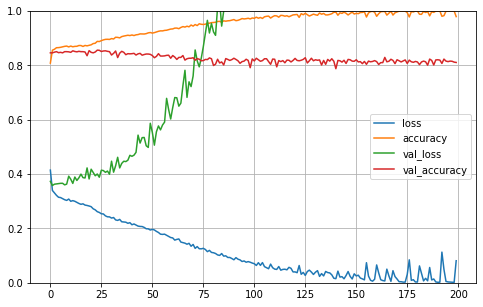

accuracy: 85.60%
COMPILE...
...COMPILED
FIT
Epoch 1/200
453/453 [==============================] - 2s 5ms/step - loss: 0.4175 - accuracy: 0.8063 - val_loss: 0.3554 - val_accuracy: 0.8554
Epoch 2/200
453/453 [==============================] - 2s 5ms/step - loss: 0.3442 - accuracy: 0.8532 - val_loss: 0.3331 - val_accuracy: 0.8597
Epoch 3/200
453/453 [==============================] - 1s 3ms/step - loss: 0.3271 - accuracy: 0.8600 - val_loss: 0.3377 - val_accuracy: 0.8566
Epoch 4/200
453/453 [==============================] - 3s 6ms/step - loss: 0.3262 - accuracy: 0.8615 - val_loss: 0.3339 - val_accuracy: 0.8634
Epoch 5/200
453/453 [==============================] - 1s 2ms/step - loss: 0.3234 - accuracy: 0.8632 - val_loss: 0.3345 - val_accuracy: 0.8628
Epoch 6/200
453/453 [==============================] - 1s 3ms/step - loss: 0.3180 - accuracy: 0.8670 - val_loss: 0.3603 - val_accuracy: 0.8485
Epoch 7/200
453/453 [==============================] - 1s 2ms/step - loss: 0.3135 - accuracy: 0.86

453/453 [==============================] - 1s 2ms/step - loss: 0.1995 - accuracy: 0.9223 - val_loss: 0.4691 - val_accuracy: 0.8504
Epoch 53/200
453/453 [==============================] - 1s 3ms/step - loss: 0.1982 - accuracy: 0.9246 - val_loss: 0.4470 - val_accuracy: 0.8529
Epoch 54/200
453/453 [==============================] - 1s 3ms/step - loss: 0.1976 - accuracy: 0.9218 - val_loss: 0.4610 - val_accuracy: 0.8287
Epoch 55/200
453/453 [==============================] - 2s 5ms/step - loss: 0.1988 - accuracy: 0.9243 - val_loss: 0.4524 - val_accuracy: 0.8423
Epoch 56/200
453/453 [==============================] - 1s 2ms/step - loss: 0.1918 - accuracy: 0.9252 - val_loss: 0.4586 - val_accuracy: 0.8436
Epoch 57/200
453/453 [==============================] - 1s 2ms/step - loss: 0.1876 - accuracy: 0.9289 - val_loss: 0.4998 - val_accuracy: 0.8467
Epoch 58/200
453/453 [==============================] - 1s 3ms/step - loss: 0.1860 - accuracy: 0.9278 - val_loss: 0.4751 - val_accuracy: 0.8349
Epoch

Epoch 109/200
453/453 [==============================] - 1s 2ms/step - loss: 0.0560 - accuracy: 0.9799 - val_loss: 1.3716 - val_accuracy: 0.8206
Epoch 110/200
453/453 [==============================] - 1s 2ms/step - loss: 0.0535 - accuracy: 0.9810 - val_loss: 1.3422 - val_accuracy: 0.8094
Epoch 111/200
453/453 [==============================] - 1s 2ms/step - loss: 0.0679 - accuracy: 0.9727 - val_loss: 1.3743 - val_accuracy: 0.8237
Epoch 112/200
453/453 [==============================] - 1s 2ms/step - loss: 0.0531 - accuracy: 0.9812 - val_loss: 1.3851 - val_accuracy: 0.8163
Epoch 113/200
453/453 [==============================] - 1s 2ms/step - loss: 0.0540 - accuracy: 0.9800 - val_loss: 1.4021 - val_accuracy: 0.8082
Epoch 114/200
453/453 [==============================] - 1s 2ms/step - loss: 0.0456 - accuracy: 0.9848 - val_loss: 1.4831 - val_accuracy: 0.8181
Epoch 115/200
453/453 [==============================] - 1s 2ms/step - loss: 0.0464 - accuracy: 0.9833 - val_loss: 1.5359 - val_ac

453/453 [==============================] - 1s 3ms/step - loss: 0.0199 - accuracy: 0.9948 - val_loss: 2.4847 - val_accuracy: 0.7958
Epoch 166/200
453/453 [==============================] - 1s 2ms/step - loss: 0.0245 - accuracy: 0.9929 - val_loss: 2.4013 - val_accuracy: 0.8107
Epoch 167/200
453/453 [==============================] - 1s 2ms/step - loss: 0.0218 - accuracy: 0.9923 - val_loss: 2.3421 - val_accuracy: 0.8125
Epoch 168/200
453/453 [==============================] - 1s 2ms/step - loss: 0.0228 - accuracy: 0.9933 - val_loss: 2.3838 - val_accuracy: 0.8132
Epoch 169/200
453/453 [==============================] - 1s 3ms/step - loss: 0.0145 - accuracy: 0.9954 - val_loss: 2.3934 - val_accuracy: 0.8119
Epoch 170/200
453/453 [==============================] - 1s 2ms/step - loss: 0.0179 - accuracy: 0.9935 - val_loss: 2.4339 - val_accuracy: 0.8094
Epoch 171/200
453/453 [==============================] - 1s 3ms/step - loss: 0.0284 - accuracy: 0.9901 - val_loss: 2.3654 - val_accuracy: 0.8076

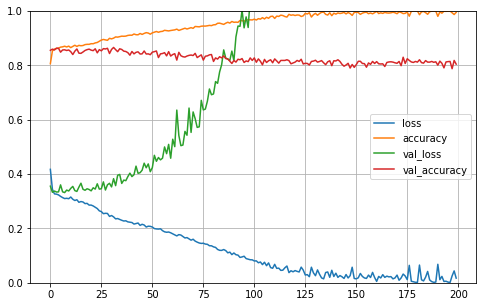

accuracy: 86.59%
COMPILE...
...COMPILED
FIT
Epoch 1/200
453/453 [==============================] - 2s 4ms/step - loss: 0.4172 - accuracy: 0.8096 - val_loss: 0.3433 - val_accuracy: 0.8516
Epoch 2/200
453/453 [==============================] - 2s 4ms/step - loss: 0.3440 - accuracy: 0.8530 - val_loss: 0.3479 - val_accuracy: 0.8579
Epoch 3/200
453/453 [==============================] - 1s 2ms/step - loss: 0.3307 - accuracy: 0.8623 - val_loss: 0.3754 - val_accuracy: 0.8324
Epoch 4/200
453/453 [==============================] - 2s 3ms/step - loss: 0.3199 - accuracy: 0.8665 - val_loss: 0.3383 - val_accuracy: 0.8523
Epoch 5/200
453/453 [==============================] - 1s 2ms/step - loss: 0.3196 - accuracy: 0.8650 - val_loss: 0.3737 - val_accuracy: 0.8293
Epoch 6/200
453/453 [==============================] - 1s 2ms/step - loss: 0.3161 - accuracy: 0.8666 - val_loss: 0.3355 - val_accuracy: 0.8579
Epoch 7/200
453/453 [==============================] - 1s 3ms/step - loss: 0.3131 - accuracy: 0.86

453/453 [==============================] - 1s 2ms/step - loss: 0.1847 - accuracy: 0.9243 - val_loss: 0.5391 - val_accuracy: 0.8374
Epoch 55/200
453/453 [==============================] - 1s 2ms/step - loss: 0.1810 - accuracy: 0.9265 - val_loss: 0.5025 - val_accuracy: 0.8405
Epoch 56/200
453/453 [==============================] - 1s 2ms/step - loss: 0.1762 - accuracy: 0.9316 - val_loss: 0.5161 - val_accuracy: 0.8399
Epoch 57/200
453/453 [==============================] - 1s 2ms/step - loss: 0.1792 - accuracy: 0.9294 - val_loss: 0.5188 - val_accuracy: 0.8448
Epoch 58/200
453/453 [==============================] - 1s 2ms/step - loss: 0.1718 - accuracy: 0.9308 - val_loss: 0.5302 - val_accuracy: 0.8312
Epoch 59/200
453/453 [==============================] - 1s 2ms/step - loss: 0.1771 - accuracy: 0.9299 - val_loss: 0.5391 - val_accuracy: 0.8299
Epoch 60/200
453/453 [==============================] - 1s 2ms/step - loss: 0.1653 - accuracy: 0.9352 - val_loss: 0.5387 - val_accuracy: 0.8312
Epoch

453/453 [==============================] - 1s 2ms/step - loss: 0.0850 - accuracy: 0.9687 - val_loss: 1.2280 - val_accuracy: 0.8194
Epoch 111/200
453/453 [==============================] - 1s 2ms/step - loss: 0.0724 - accuracy: 0.9721 - val_loss: 1.1873 - val_accuracy: 0.8063
Epoch 112/200
453/453 [==============================] - 1s 2ms/step - loss: 0.0690 - accuracy: 0.9750 - val_loss: 1.3338 - val_accuracy: 0.8225
Epoch 113/200
453/453 [==============================] - 1s 2ms/step - loss: 0.0636 - accuracy: 0.9763 - val_loss: 1.3980 - val_accuracy: 0.8231
Epoch 114/200
453/453 [==============================] - 1s 2ms/step - loss: 0.0807 - accuracy: 0.9696 - val_loss: 1.4669 - val_accuracy: 0.8231
Epoch 115/200
453/453 [==============================] - 1s 2ms/step - loss: 0.0589 - accuracy: 0.9783 - val_loss: 1.3490 - val_accuracy: 0.8150
Epoch 116/200
453/453 [==============================] - 1s 2ms/step - loss: 0.0633 - accuracy: 0.9781 - val_loss: 1.3718 - val_accuracy: 0.8156

453/453 [==============================] - 1s 2ms/step - loss: 0.0158 - accuracy: 0.9942 - val_loss: 2.4150 - val_accuracy: 0.8076
Epoch 167/200
453/453 [==============================] - 1s 2ms/step - loss: 0.0472 - accuracy: 0.9876 - val_loss: 2.3637 - val_accuracy: 0.8125
Epoch 168/200
453/453 [==============================] - 1s 2ms/step - loss: 0.0254 - accuracy: 0.9905 - val_loss: 2.3872 - val_accuracy: 0.8057
Epoch 169/200
453/453 [==============================] - 1s 2ms/step - loss: 0.0067 - accuracy: 0.9988 - val_loss: 2.4586 - val_accuracy: 0.8107
Epoch 170/200
453/453 [==============================] - 1s 2ms/step - loss: 0.0384 - accuracy: 0.9860 - val_loss: 2.4366 - val_accuracy: 0.8001
Epoch 171/200
453/453 [==============================] - 1s 2ms/step - loss: 0.0441 - accuracy: 0.9863 - val_loss: 2.4777 - val_accuracy: 0.8156
Epoch 172/200
453/453 [==============================] - 1s 2ms/step - loss: 0.0168 - accuracy: 0.9941 - val_loss: 2.4128 - val_accuracy: 0.8038

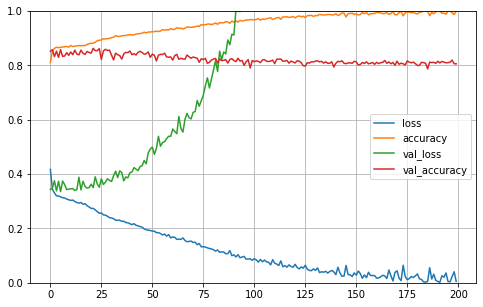

accuracy: 86.28%
COMPILE...
...COMPILED
FIT
Epoch 1/200
453/453 [==============================] - 2s 4ms/step - loss: 0.4279 - accuracy: 0.8009 - val_loss: 0.3409 - val_accuracy: 0.8516
Epoch 2/200
453/453 [==============================] - 2s 4ms/step - loss: 0.3429 - accuracy: 0.8525 - val_loss: 0.3367 - val_accuracy: 0.8585
Epoch 3/200
453/453 [==============================] - 2s 4ms/step - loss: 0.3245 - accuracy: 0.8630 - val_loss: 0.3255 - val_accuracy: 0.8597
Epoch 4/200
453/453 [==============================] - 2s 3ms/step - loss: 0.3215 - accuracy: 0.8637 - val_loss: 0.3256 - val_accuracy: 0.8616
Epoch 5/200
453/453 [==============================] - 1s 2ms/step - loss: 0.3146 - accuracy: 0.8669 - val_loss: 0.3249 - val_accuracy: 0.8566
Epoch 6/200
453/453 [==============================] - 1s 3ms/step - loss: 0.3147 - accuracy: 0.8662 - val_loss: 0.3299 - val_accuracy: 0.8585
Epoch 7/200
453/453 [==============================] - 1s 2ms/step - loss: 0.3119 - accuracy: 0.87

Epoch 53/200
453/453 [==============================] - 1s 2ms/step - loss: 0.2013 - accuracy: 0.9198 - val_loss: 0.4603 - val_accuracy: 0.8479
Epoch 54/200
453/453 [==============================] - 1s 2ms/step - loss: 0.1951 - accuracy: 0.9223 - val_loss: 0.4958 - val_accuracy: 0.8541
Epoch 55/200
453/453 [==============================] - 1s 2ms/step - loss: 0.1911 - accuracy: 0.9244 - val_loss: 0.5001 - val_accuracy: 0.8485
Epoch 56/200
453/453 [==============================] - 1s 2ms/step - loss: 0.1923 - accuracy: 0.9223 - val_loss: 0.4838 - val_accuracy: 0.8523
Epoch 57/200
453/453 [==============================] - 1s 2ms/step - loss: 0.1889 - accuracy: 0.9252 - val_loss: 0.5314 - val_accuracy: 0.8523
Epoch 58/200
453/453 [==============================] - 1s 2ms/step - loss: 0.1836 - accuracy: 0.9296 - val_loss: 0.5499 - val_accuracy: 0.8510
Epoch 59/200
453/453 [==============================] - 1s 2ms/step - loss: 0.1845 - accuracy: 0.9249 - val_loss: 0.5038 - val_accuracy:

Epoch 110/200
453/453 [==============================] - 1s 2ms/step - loss: 0.1016 - accuracy: 0.9616 - val_loss: 1.1156 - val_accuracy: 0.8256
Epoch 111/200
453/453 [==============================] - 1s 3ms/step - loss: 0.1002 - accuracy: 0.9621 - val_loss: 1.1498 - val_accuracy: 0.8237
Epoch 112/200
453/453 [==============================] - 1s 2ms/step - loss: 0.0893 - accuracy: 0.9663 - val_loss: 1.1117 - val_accuracy: 0.8150
Epoch 113/200
453/453 [==============================] - 1s 2ms/step - loss: 0.0838 - accuracy: 0.9694 - val_loss: 1.2185 - val_accuracy: 0.8268
Epoch 114/200
453/453 [==============================] - 1s 2ms/step - loss: 0.0885 - accuracy: 0.9675 - val_loss: 1.0893 - val_accuracy: 0.8194
Epoch 115/200
453/453 [==============================] - 1s 2ms/step - loss: 0.0912 - accuracy: 0.9659 - val_loss: 1.1956 - val_accuracy: 0.8225
Epoch 116/200
453/453 [==============================] - 1s 2ms/step - loss: 0.0798 - accuracy: 0.9712 - val_loss: 1.2441 - val_ac

453/453 [==============================] - 1s 2ms/step - loss: 0.0235 - accuracy: 0.9926 - val_loss: 2.4589 - val_accuracy: 0.8200
Epoch 167/200
453/453 [==============================] - 1s 2ms/step - loss: 0.0140 - accuracy: 0.9963 - val_loss: 2.3955 - val_accuracy: 0.8256
Epoch 168/200
453/453 [==============================] - 1s 2ms/step - loss: 0.0284 - accuracy: 0.9905 - val_loss: 2.3419 - val_accuracy: 0.8138
Epoch 169/200
453/453 [==============================] - 1s 2ms/step - loss: 0.0410 - accuracy: 0.9866 - val_loss: 2.2386 - val_accuracy: 0.8206
Epoch 170/200
453/453 [==============================] - 1s 2ms/step - loss: 0.0193 - accuracy: 0.9936 - val_loss: 2.4439 - val_accuracy: 0.8132
Epoch 171/200
453/453 [==============================] - 1s 2ms/step - loss: 0.0313 - accuracy: 0.9893 - val_loss: 2.5301 - val_accuracy: 0.8150
Epoch 172/200
453/453 [==============================] - 1s 2ms/step - loss: 0.0279 - accuracy: 0.9901 - val_loss: 2.4252 - val_accuracy: 0.8194

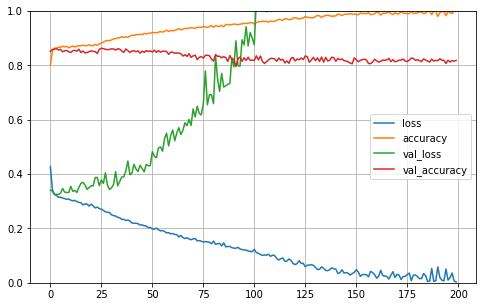

accuracy: 86.28%

5-way Cross Validation mean 86.48% (+/- 0.67%)
Done


In [10]:
print ("Cross valiation")
do_cross_validation(X_train,y_train,model)  
print ("Done")